## Group 25 
### Olof Sjögren, 5h
### Romain Theodet, 5h

# Question 1

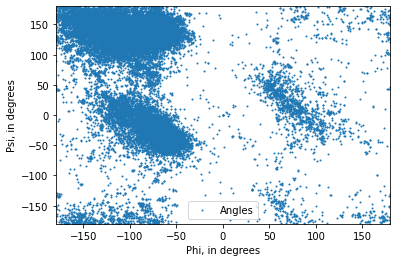

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Table of protein data
table = pd.read_csv("./data_all.csv").dropna()

# Axis
x = table["phi"]
y = table["psi"]
aminoAcidNames = table["residue name"]

# Scatter plot
plt.scatter(x, y, label="Angles", s=1)
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.xlabel("Phi, in degrees")
plt.ylabel("Psi, in degrees")
plt.legend()
plt.show()

# Question 2
## a.

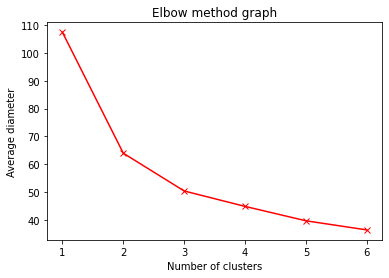

In [ ]:
from sklearn.cluster import KMeans
import math

# Create the data array as 2 columns : one for phi, one for psi
X = np.array([ x, y ]).transpose()

# Calculate different distances to be able to use the Elbow Method to find an optimal k-value.
distances = []
for k in range(1, 7):
    # Specify the number of clusters (k) and fit the data X
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

    closestCluster = kmeans.labels_
    currentSquaredError = 0

    # Calculate square of Euclidean distance between each point and its cluster center
    for i in range(len(X)):
        currentCenter = kmeans.cluster_centers_[closestCluster[i]]
        currentSquaredError += (X[i, 0] - currentCenter[0]) ** 2 + (X[i, 1] - currentCenter[1]) ** 2

    # Add the result to the list
    distances.append(math.sqrt(currentSquaredError / len(X)))

# Plotting the elbow method graph
plt.plot([xCoord for xCoord in range(1, 7)], distances, c="red", marker="x")
plt.xlabel("Number of clusters")
plt.ylabel("Average diameter")
plt.title("Elbow method graph")
plt.show()


To  find an optimal k-value we decided to use the elbow method.
Looking at the plot, `k = 3` seems to be an appropriate fit, as it is where the supposed "elbow" is located. `k = 2` also seems to be an appropriate value although looking at the graph from question 1 we can reasonably differentiate more than 2 clusters.

Thus we find `k = 3` to be an appropriate value for k.

## b.

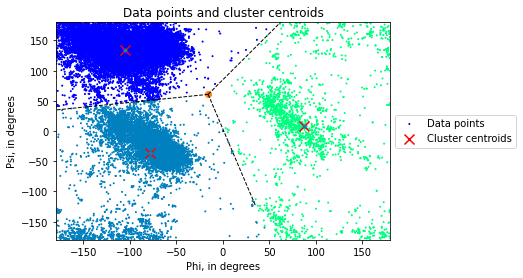

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# kmeans using k=3 as determined from a.
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Plotting the Voronoi diagram of the cluser centers
voronoi_plot_2d(Voronoi(kmeans.cluster_centers_))

# Plotting the cluster centers and the data points on a 2D plane
plt.scatter(x, y, s=1, c=kmeans.labels_, cmap="winter", label="Data points")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c="red", marker="x", label="Cluster centroids")

# Plot accompanying labels, title, and legend
plt.xlabel("Phi, in degrees")
plt.ylabel("Psi, in degrees")
plt.title("Data points and cluster centroids")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlim([-180, 180])
plt.ylim([-180, 180])

plt.show()

## c.

The clusters found seem reasonable, as we could identify from the beginning at least 3 different clusters by simply looking at the graph. However, there is a lot of noise, especially in the 3 other corners (bottom and top right). This could reasonably be more clusters however, the kmeans might not pick these corners as clusters but might instead split another correctly identified cluster. You could reasnoably say that there even might be more clusters, for example in the bottom left and right.

Furthermore, looking at our answer for d, it might not even be appropriate to make a cluster in, say, the bottom left.

## d.

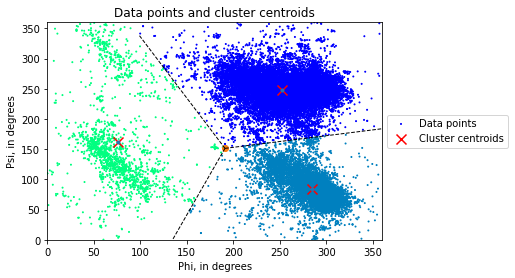

In [ ]:
# Shift the data
xShifted = [ (elt + 360) % 360 for elt in x ]
yShifted = [ (elt + 360 - 250) % 360 for elt in y ]

X = np.array([ xShifted, yShifted ]).transpose()

# kmeans using k=3 as determined from a.
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Plotting the Voronoi diagram of the cluser centers
voronoi_plot_2d(Voronoi(kmeans.cluster_centers_))

# Plotting the cluster centers and the data points on a 2D plane
plt.scatter(xShifted, yShifted, s=1, c=kmeans.labels_, cmap="winter", label="Data points")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c="red", marker="x", label="Cluster centroids")

# Plot accompanying labels, title, and legend
plt.xlabel("Phi, in degrees")
plt.ylabel("Psi, in degrees")
plt.title("Data points and cluster centroids")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.show()

Since the angles are periodic, we can shift them to avoid splitting clusters.

Indeed, we can see above that all corners are full of points,
which highlights the fact that the original data should be shifted for the kmeans to make more sense.
Comparing to the graph in b, the clusters are now significantly more distinct .

This is completely legal, as there is no geometrical difference between an angle of -180° and +180°, but it is a huge difference for our algorithms and the way the data is presented and handled.

# Question 3
## a.

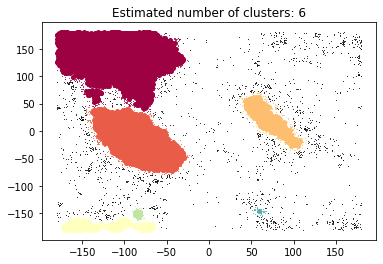

In [ ]:
from sklearn.cluster import DBSCAN

# DBSCAN is used in a lot of upcoming questions so a function was created to both cluster using DBSCAN and plot the resulting clusters and graph.
def showDBSCAN(xValues, yValues, eps, minSamples, title, noiseMessage = None):
    # Data as a vector of 2 columns and n rows
    X = np.array([ xValues, yValues ]).transpose()

    # Clustering using the DBSCAN model
    db = DBSCAN(eps=eps, min_samples=minSamples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # Unique labels, used for the colors
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=5, markeredgewidth=0)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=1, markeredgewidth=0)

    plt.title(f"{title}: {n_clusters_}")
    plt.show()

    if noiseMessage is not None:
        # If we want, we can add a print with the percentage of noise points
        notNoiseCount = len(list(labels))
        print(f"{noiseMessage}: {n_noise_} / {notNoiseCount}, so around {round(n_noise_ / notNoiseCount * 1000)/10} %")

showDBSCAN(x, y, 9.1, 45, "Estimated number of clusters")

We sort of combined part **a** and **b** by plotting the graph in **a** and adjusting the values from the resulting graph. 

Our methodology here was a lot of trial and error. We started out with some values for the hyperparamters and then adjusted them in accordance to the resulting clusters shown on the graph. Looking at the resulting graph and the clusters show is vital to ensure the clusters make sense and are meaningful. Then increasing and decreasing the hyperparameters to make reasonable clusters.

### i.
Since the data set is very large (29 000+ entries) we figured the minimum-number-of-samples-in-the-neighbourhood (minN) should also be relatively high. A low minN creates a lot of different clusters and a too high minN does the opposite. As mentioned the data set is large, thus we want to include quite a lot of neightbours until we classify something as a cluster. This makes sure the clusters are actually representing something meaningful. 

### ii.

We wanted to split the two groups on the left, as they don't look like they should be linked with each other.
To do so, we chose an epsion not too big to avoid merging these two groups and avoid creating large amounts of groups,
but at the same time not too small to keep the group on the right and the one at the bottom (even though we know since the question `2.d` that they can represent the same group).

## b.
See **a** above for the scatter plot with the clusters.\
Below is the bar chart showing which amino acid residue types are the most frequent outliers.

Estimated number of noise points: 1791 / 29369, so around 6.1 %


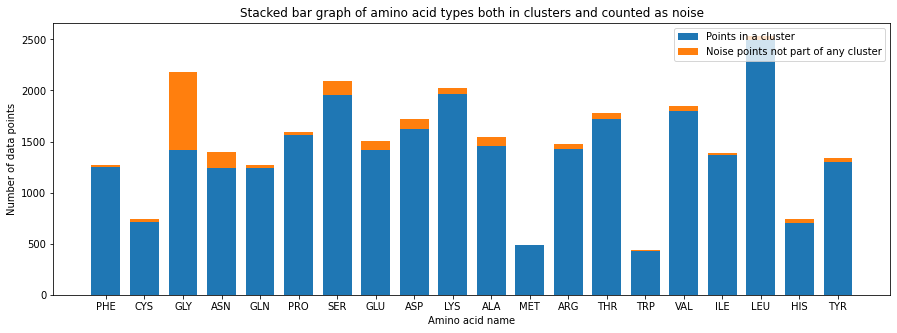

In [ ]:
notNoiseCount = len(list(labels))
print(f"Estimated number of noise points: {n_noise_} / {notNoiseCount}, so around {round(n_noise_ / notNoiseCount * 1000)/10} %")

# Map of all noise points
data = {}
# Map of all non-noise points
dataIn = {}

for i in range(len(labels)):
    # Each point is either noise or not
    name = aminoAcidNames[i]
    if labels[i] == -1:
        data[name] = data.get(name, 0) + 1
    else:
        dataIn[name] = dataIn.get(name, 0) + 1

# x values, all unique acid names
xBar = list(set(aminoAcidNames))
# y values
yNotInBar = [data.get(elt, 0) for elt in xBar]
yInBar = [dataIn.get(elt, 0) for elt in xBar]

# Plot
plt.figure(figsize=(15, 5))
plt.bar(xBar, yInBar, width=0.75, label="Points in a cluster")
plt.bar(xBar, yNotInBar, bottom=yInBar, width=0.75, label="Noise points not part of any cluster")
plt.xlabel("Amino acid name")
plt.ylabel("Number of data points")
plt.legend(loc="upper right")
plt.title("Stacked bar graph of amino acid types both in clusters and counted as noise")
plt.show()


The bar graph shows each amino acid type and how many of the type were included in a cluster as well as how many of them were classified as noise and subsequently not part of any cluster.

We can see that for the most part all of the amino acids were included in a cluster with the exception of *GLY* which was a major outlier. This might indicate that a lot of *GLY* were in a very sparse cluster which did not meet the threshold set for our DBSCAN clustering. A solution for this noise would be to shift the data to increase the cluster size, like done in part `4.d`.

## c.

With K-means, there are no noise points and clusters are clearly split, while DBSCAN shows us the quality of the data with the number of noise points.

We get a problem in the following situation : 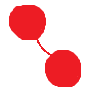

DBSCAN will not be able to split the two obvious clusters in two, because they are technically linked together, while K-means will be able to do so as long as we specify the right amount of points (here, 2). 

This is something we noticed for the two left clusters : with DBSCAN, these clearly different clusters were mixing up and merging with each other, but changing the parameters would make other clusters disappear.
However when the clusters had clear separatins between each other, the DBSCAN is able to accurately mark clusters with distinct and intricate shapes. K-means struggles at this.

## d.

DBSCAN is not very robust to small changes in minimum number of samples in the neighbourhood for a point to be considered as a core point. The same applies for the epsilon value. This is because a small variation might include or exclude whole other clusters. This makes DBSCAN best when it is fine tuned to create appropriate clusters. If the clusters are densley packed but sparse between each other, i.e. clear separations of the clusters, DBSCAN's robustness increases. However if the opposite is true and the edges between clusters are blurred and overlap DBSCAN becomes incredbily sensitive to changes in the hyperparameters.

# Question 4

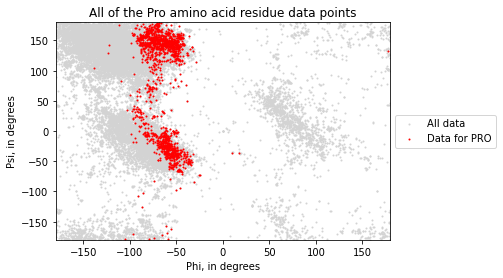

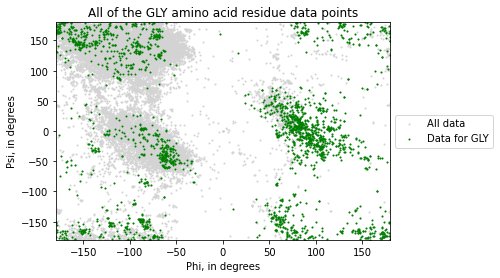

In [ ]:
# Table of protein data
tablePRO = table[ table["residue name"] == "PRO" ]
tableGLY = table[ table["residue name"] == "GLY" ]

# Axis
x = table["phi"]
y = table["psi"]

xPRO = tablePRO["phi"]
yPRO = tablePRO["psi"]

xGLY = tableGLY["phi"]
yGLY = tableGLY["psi"]

# Scatter plot for PRO
plt.scatter(x, y, label="All data", s=1, color="lightgray")
plt.scatter(xPRO, yPRO, label="Data for PRO", s=1, color="red")
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.title("All of the Pro amino acid residue data points")
plt.xlabel("Phi, in degrees")
plt.ylabel("Psi, in degrees")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Scatter plot GLY
plt.scatter(x, y, label="All data", s=1, color="lightgrey")
plt.scatter(xGLY, yGLY, label="Data for GLY", s=1, color="green")
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.title("All of the GLY amino acid residue data points")
plt.xlabel("Phi, in degrees")
plt.ylabel("Psi, in degrees")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


Now we isolate only the two specific data points for PRO and GLY and cluster these specifically.

First, we will keep the previous hyperparameters to compare, and then try to find a better model, more specific for the amino acid studied.

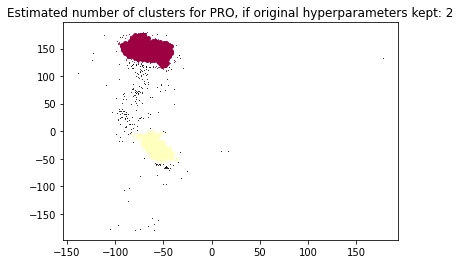

Estimated number of noise points for PRO, if original hyperparameters kept: 259 / 1596, so around 16.2 %


In [ ]:
showDBSCAN(xPRO, yPRO, 9.1, 45, "Estimated number of clusters for PRO, if original hyperparameters kept", "Estimated number of noise points for PRO, if original hyperparameters kept")


When keeping the original model's hyperparameters the clusters found are reasonable, although the noise percentage is a bit high. 
The hyper parameters could reasonably be adjusted (see below) while still creating coherent and meaningful clusters.

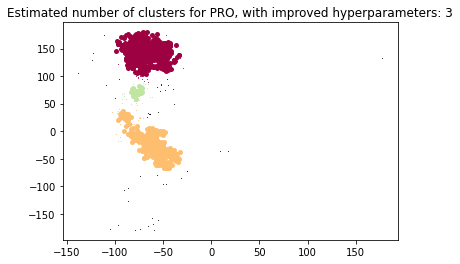

Estimated number of noise points for PRO, with improved hyperparameters: 44 / 1596, so around 2.8 %


In [ ]:
showDBSCAN(xPRO, yPRO, 15, 30, "Estimated number of clusters for PRO, with improved hyperparameters", "Estimated number of noise points for PRO, with improved hyperparameters")


If we compare the global hyperparameters results with some tailored model with better hyperparameters, we can clearly see that there exists a model way better than the global one if we're only interested in PRO. Maybe we shouldn't try to find a model for all amino acids then, since it appears that every amino acid is quite independant with its own shape and density. 

These data points weren't as spread out as the original data set and formed some reasonable clusters. You can see that they form a part of the clusters found in the original data set, just smaller and perhaps a bit more generous in what is considered a cluster.

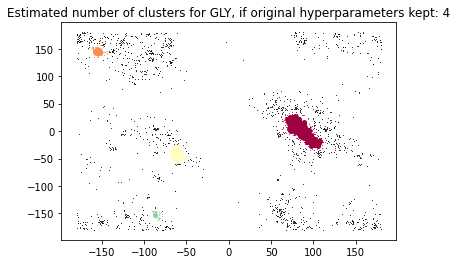

Estimated number of noise points for GLY, if original hyperparameters kept: 1554 / 2176, so around 71.4 %


In [ ]:
showDBSCAN(xGLY, yGLY, 9.1, 45, "Estimated number of clusters for GLY, if original hyperparameters kept", "Estimated number of noise points for GLY, if original hyperparameters kept")


As we can see above, by keeping the original hyperparameters for the GLY data points, the large majority of data points are considered noise and the clusters are very small.
This indicates that the model needs to be tuned by changing the hyperparamteres (see below).

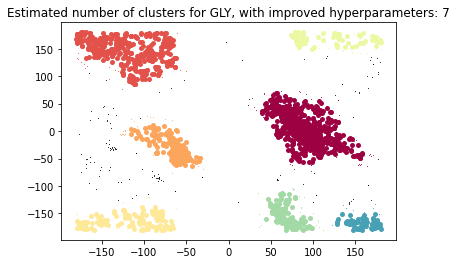

Estimated number of noise points for GLY, with improved hyperparameters: 128 / 2176, so around 5.9 %


In [ ]:
showDBSCAN(xGLY, yGLY, 19, 20, "Estimated number of clusters for GLY, with improved hyperparameters", "Estimated number of noise points for GLY, with improved hyperparameters")


The overall structure is similar to that of the original data set and formed similar clusters. Although this model was a lot more generous with what is called a cluster since there isn't as many data points, thus creating more clusters in what the original model consider noise in the complete data set. The major difference is the amount of data points and the hyperparameters for this question has to be modified. Comparing the noise percentage of 6.1% calculated in question 3.b with the noise in this question we get a similar percentage.
This fairly low percentage of noise couldn't have been achieved without changing the model's hyperparameters.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ab83f1d1-4f39-4251-b899-1ad25d544179' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>